# Homework 3

### Due: Wed Nov. 21 @ 9pm

In this homework we will be performing model evaluation, model selection and feature selection in both a regression and classification setting.

The data we will be looking at are a subset of home sales data from King County, Washington, as we might see on a real-estate website.


## Instructions

Follow the comments below and fill in the blanks (____) to complete.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

## Part 1: Regression

Here we try to build a model to predict adjusted sales price from a set of building features.

### Load data

In [2]:
# Load data from file
# DO NOT CHANGE THIS (needed for grading)
infile_name = '../data/house_sales_subset_normed.csv'
df = pd.read_csv(infile_name)

# Use a subset of the columns as features
X = df[['SqFtTotLiving_norm','SqFtLot_norm','Bathrooms','Bedrooms','TrafficNoise']]

# Extract the target, adjusted sale price, in values of $100,000
# Note: the '_r' here is denote the different targets for regression and classification
y_r = df.AdjSalePrice / 100000

### Create a held-aside set

In [4]:
# Split into 80% train and 20% test using train_test_split and random_state=42
from sklearn.model_selection import train_test_split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_r, test_size=.2, random_state=42)

### Measure baseline performance

In [5]:
# Instantiate and train a dummy model on the training set using DummyRegressor
from sklearn.dummy import DummyRegressor
dummy_r = DummyRegressor().fit(X_train_r,y_train_r)

In [6]:
# Calculate and print RMSE training set error of the dummy model
from sklearn.metrics import mean_squared_error
dummy_r_training_rsme = np.sqrt(mean_squared_error(dummy_r.predict(X_train_r),y_train_r))
print('dummy RMSE: {:.3f}'.format(dummy_r_training_rsme))

dummy RMSE: 2.162


In [7]:
# Calculate and print the R2 training set score of the dummy model
# hint: can use models 'score' function
dummy_r_training_r2 = dummy_r.score(X_train_r,y_train_r)
print('dummy R2: {:.3f}'.format(dummy_r_training_r2))

dummy R2: 0.000


In [9]:
# Calculate and print the mean 5-fold cross valication R2 score of the dummy model
from sklearn.model_selection import cross_val_score
dummy_r_cv = cross_val_score(dummy_r,X_train_r,y_train_r,cv=5)
print('dummy mean cv R2: {:.3f}'.format(np.mean(dummy_r_cv)))

dummy mean cv R2: -0.000


### Measure performance of Linear Regression

In [10]:
# Instantiate and train a LinearRegression model on the training set
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_r,y_train_r)

In [12]:
# Calculate RMSE training set error of the linear model
# There should be an improvement over the dummy model
lr_rmse = np.sqrt(mean_squared_error(lr.predict(X_train_r),y_train_r))
print('lr RMSE: {:.3f}'.format(lr_rmse))

lr RMSE: 1.584


In [14]:
# Calculate and print the R2 training set score of the linear model
lr_r2 = lr.score(X_train_r,y_train_r)
print('lr R2: {:.4f}'.format(lr_r2))

lr R2: 0.4630


In [15]:
# Calculate mean 5-fold Cross Validation R2 score of the linear model on the training set using cross_val_score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_train_r, y_train_r, cv=5)
print('lr mean cv R2: {:.4f}'.format(np.mean(scores)))

lr mean cv R2: 0.4616


### Model selection

In [17]:
# We'll also train an Elastic Net model using regularization
# Perform GridSearch over different proportions of the l1_ratio = [.1,.5,.9,1] using the training set
# The only parameter in our search is this l1_ratio
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
params = {'l1_ratio':[.1,.5,.9,1]}
gs = GridSearchCV(ElasticNet(), params).fit(X_train_r, y_train_r)

In [18]:
# Print out the best R2 score found using grid search and the best parameter setting found
print('gs best R2 score : {:.4f}'.format(gs.best_score_))
print('gs best params: {}'.format(gs.best_params_))

gs best R2 score : 0.2989
gs best params: {'l1_ratio': 0.1}


In [19]:
# Using the best parameter setting found via cross validation in the step before
#   calculate and print the mean 5-fold cv R2 score on the training set
en = ElasticNet(l1_ratio = .1)
scores = cross_val_score(en, X_train_r, y_train_r, cv=5)
print('en mean cv R2  : {:.4f}'.format(np.mean(scores)))

en mean cv R2  : 0.2990


In [20]:
# Retrain the ElasticNet model on the full training set and get predictions on the full training set
y_hat = en.fit(X_train_r,y_train_r).predict(X_train_r)

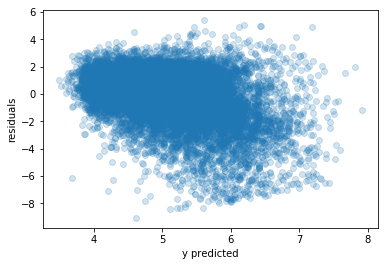

In [22]:
# Plot predictions (x-axis) vs residuals (y-axis) using plt.scatter() with alpha=0.2
# Set axis names appropriately
# recall: residual = y_hat - y
residuals = y_hat - y_train_r
_ = plt.scatter(y_hat, residuals, alpha=0.2)
_ = plt.xlabel('y predicted')
_ = plt.ylabel('residuals')

### Evaluate trained models on Test

In [23]:
# Using our trained models, calculate RMSE on the test set
print('dummy_r test RMSE  : {:.3f}'.format(np.sqrt(mean_squared_error(dummy_r.predict(X_test_r),y_test_r))))
print('lr test RMSE       : {:.3f}'.format(np.sqrt(mean_squared_error(lr.predict(X_test_r),y_test_r))))
print('en test RMSE       : {:.3f}'.format(np.sqrt(mean_squared_error(en.predict(X_test_r),y_test_r))))

dummy_r test RMSE  : 2.152
lr test RMSE       : 1.582
en test RMSE       : 1.800


### Feature selection

In [24]:
# Using the ElasticNet model we trained before, what features have a non-zero coefficient?
print('kept columns: {}'.format(X.columns.values[en.coef_ != 0]))

kept columns: ['SqFtTotLiving_norm' 'Bathrooms' 'Bedrooms']


In [25]:
# Now, select the top 3 most informative features from the trained model 
#   using SelectKBest and the f_regression metric
# First, instantiate and fit SelectKbest on the training set
from sklearn.feature_selection import SelectKBest, f_regression
skb = SelectKBest(f_regression, k=3).fit(X_train_r, y_train_r)

In [26]:
# Print out the selected features using skb.get_support() and the column names from X_train_r
# In this case, they should match the features kept by the ElasticNet model
kept_columns = X_train_r.columns.values[skb.get_support()]
print('kept columns: {}'.format(kept_columns))

kept columns: ['SqFtTotLiving_norm' 'Bathrooms' 'Bedrooms']


---

## Part 2: Classification

Here we try to build a model to predict low vs. high adjusted sales price.

### Create classification target

In [27]:
# First, we create a binary target by thresholding at the median of our AdjSalePrice in $100,000
y_c = (df.AdjSalePrice > df.AdjSalePrice.median()).astype(int)

In [28]:
# What is the proportion of 'high' labels in our dataset
print('proportion of high to low: {:.3f}'.format(sum(y_c)/float(len(y_c))))

proportion of high to low: 0.500


### Create a held-aside set

In [29]:
# Split into 80% train and 20% test using train_test_split with random_state=42
# Use our new y_c target and the same X we used for regression
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_c, test_size=0.2, random_state=42)

### Measure baseline performance

In [30]:
# Train a dummy classification model on the training set
from sklearn.dummy import DummyClassifier
dummy_c = DummyClassifier().fit(X_train_c, y_train_c)

In [31]:
# Calculate training set Accuracy of the dummy classifier
# This should be close to the original proportion of low to high
dummy_c_acc = dummy_c.score(X_train_c, y_train_c)
print('dummy accuracy: {:.3f}'.format(dummy_c_acc))

dummy accuracy: 0.502


In [33]:
# Get P(y=1|x) for the test set using the dummy model (we'll use this later)
# Note: we only want P(y=1|x) even though predict_proba returns two columns
pypos_dummy = dummy_c.predict_proba(X_test_c)[:,1]

### Measure performance of a Logistic Regression model

In [34]:
# Instantiate and train a logistic regression model using default hyperparameters
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression().fit(X_train_c,y_train_c)

In [35]:
# What is the training set accuracy of our logistic regression model?
trainset_acc = logr.score(X_train_c,y_train_c)
print('logr training set accuracy: {:.3f}'.format(trainset_acc))

logr training set accuracy: 0.734


In [36]:
# What is the 5 fold cross-validation accuracy of the logistic regression model on the training set?
scores = cross_val_score(logr, X_train_c, y_train_c, cv=5)
print('logr mean cv accuracy: {:.3f}'.format(np.mean(scores)))

logr mean cv accuracy: 0.734


In [37]:
# Get P(y=1|x) for the test set using the logistic regression model (we'll use this later)
pypos_logr = logr.predict_proba(X_test_c)[:,1]

### Model selection using a Random Forest model

In [38]:
# Perform 3-fold cross validated grid search over the number of trees
# The parameter settings to try are n_estimators = [5,50,100] 
# Perform the search using the training set
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators':[5,50,100]}
gs = GridSearchCV(RandomForestClassifier(),params, cv=3).fit(X_train_c,y_train_c)

/home/bgibson/anaconda3/envs/coms007/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [39]:
# Print out the best score found and the best parameter setting found
print('gs best accuracy: {:.3f}'.format(gs.best_score_))
print('gs best params  : {}'.format(gs.best_params_))

gs best accuracy: 0.750
gs best params  : {'n_estimators': 100}


In [40]:
# Retrain on the entire training set using the best number of trees found
rf = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators']).fit(X_train_c,y_train_c)

In [43]:
# get p(y=1|x) for the test set using the trained rf model
pypos_rf = rf.predict_proba(X_test_c)[:,1]

### Plotting Precision-Recall curve for the Random Forest model

In [44]:
# Plot Precision (y-axis) vs. Recall (x-axis) curve for the Random Forest model
# First calculate precision and recall using the y_test_c and pypos_rf 
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test_c, pypos_rf)

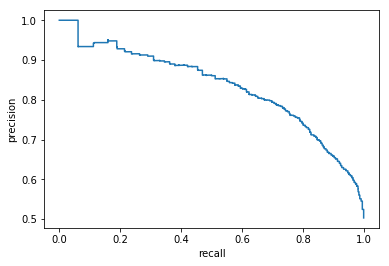

In [45]:
# Next, plot the curve using plt.step()
# Recall should be on the x-axis
# Label the x and y axes appropriately
_ = plt.step(recall,precision)
_ = plt.xlabel('recall')
_ = plt.ylabel('precision')

### Plotting ROC curves for all models

In [46]:
# Plot the ROC curves of our 3 trained models (dummy, logr and rf) 
# First calculate fpr and tpr for each model using the using y_test_c and each set of pypos values
from sklearn.metrics import roc_curve
fpr_dummy,tpr_dummy,_ = roc_curve(y_test_c, pypos_dummy)
fpr_logr,tpr_logr,_ = roc_curve(y_test_c, pypos_logr)
fpr_rf,tpr_rf,_ = roc_curve(y_test_c, pypos_rf)

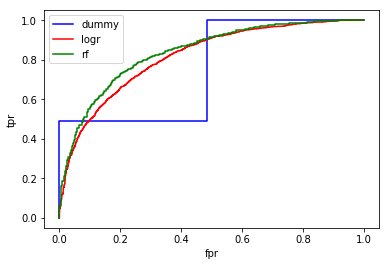

In [48]:
# Next, plot each curve using plt.step()
# Each curve should be a different color (dummy:blue, logr:red, rf:green)
# Include a legend by adding label='model_name' to each plt.step call and calling plt.legend()
# Label the axis as 'fpr' and 'tpr' appropriately
_ = plt.step(fpr_dummy,tpr_dummy,color='blue',label='dummy')
_ = plt.step(fpr_logr,tpr_logr,color='red',label='logr')
_ = plt.step(fpr_rf,tpr_rf,color='green',label='rf')
_ = plt.legend()
_ = plt.xlabel('fpr')
_ = plt.ylabel('tpr')

In [49]:
# Calculate and print the ROC AUC values on the test set for each model
from sklearn.metrics import roc_auc_score
dummy_auc = roc_auc_score(y_test_c,pypos_dummy)
logr_auc = roc_auc_score(y_test_c,pypos_logr)
rf_auc = roc_auc_score(y_test_c,pypos_rf)
print('dummy auc: {:.3f}'.format(dummy_auc))
print('logr auc : {:.3f}'.format(logr_auc))
print('rf auc   : {:.3f}'.format(rf_auc))

dummy auc: 0.503
logr auc : 0.817
rf auc   : 0.836


### Feature selection

In [50]:
# Using the trained Random Forest model, print the feature name and feature importances for each feature in X
# Each row should look like this example: SqFtLot_norm : 0.025
_ = [print('{:20s}: {:0.3f}'.format(x,v)) for x,v in zip(X.columns,rf.feature_importances_)]

SqFtTotLiving_norm  : 0.431
SqFtLot_norm        : 0.370
Bathrooms           : 0.121
Bedrooms            : 0.054
TrafficNoise        : 0.024


In [51]:
# Select the most informative features using SelectFromModel using 'mean' as threshold
# Use prefit=True since the model is already trained to save needing to retrain
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rf, threshold='mean', prefit=True)

In [52]:
# print out the selected features using X.columns and sfm.get_support()
kept_columns = X.columns[sfm.get_support()].tolist()
print('kept columns: {}'.format(kept_columns))

kept columns: ['SqFtTotLiving_norm', 'SqFtLot_norm']
